# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [1]:
from keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

169001437/169001437 [==============================] - 5s 0us/step


In [4]:
# Your code here
print("Training set shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test set shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

# Print some basic information
print("Number of classes:", len(np.unique(y_train)))

# Show a few examples from the training set
def plot_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i][0]])
        plt.axis('off')
    plt.show()


Training set shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test set shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Number of classes: 100


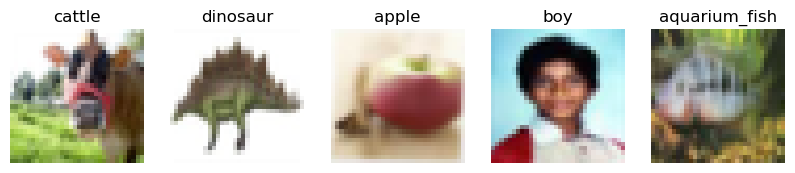

In [5]:
class_names = np.array([
     'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum',
    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark',
    'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
    'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone',
    'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
])

# Display some example images from the training set
plot_images(x_train, y_train, class_names, num_images=5)

### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [6]:
# Your code here
num_classes = len(class_names)  

In [8]:
for i, name in enumerate(class_names):
    print(f"Class index {i}: {name}")

Class index 0: apple
Class index 1: aquarium_fish
Class index 2: baby
Class index 3: bear
Class index 4: beaver
Class index 5: bed
Class index 6: bee
Class index 7: beetle
Class index 8: bicycle
Class index 9: bottle
Class index 10: bowl
Class index 11: boy
Class index 12: bridge
Class index 13: bus
Class index 14: butterfly
Class index 15: camel
Class index 16: can
Class index 17: castle
Class index 18: caterpillar
Class index 19: cattle
Class index 20: chair
Class index 21: chimpanzee
Class index 22: clock
Class index 23: cloud
Class index 24: cockroach
Class index 25: couch
Class index 26: cra
Class index 27: crocodile
Class index 28: cup
Class index 29: dinosaur
Class index 30: dolphin
Class index 31: elephant
Class index 32: flatfish
Class index 33: forest
Class index 34: fox
Class index 35: girl
Class index 36: hamster
Class index 37: house
Class index 38: kangaroo
Class index 39: keyboard
Class index 40: lamp
Class index 41: lawn_mower
Class index 42: leopard
Class index 43: lio

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Verify number of unique labels
unique_train_labels = np.unique(y_train)
print("Unique labels in y_train:", unique_train_labels)
print("Number of unique labels:", len(unique_train_labels))

# Ensure the number of classes matches the length of class_names
num_classes = len(class_names)  # This should match the number of unique labels
if num_classes != len(unique_train_labels):
    raise ValueError(f"Number of classes ({num_classes}) does not match number of unique labels ({len(unique_train_labels)})")

# Step 1: Normalize the images
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

# Step 2: Convert labels to one-hot encoded vectors
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Step 3: Split the training set into training and validation sets
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_normalized, y_train_one_hot, test_size=0.2, random_state=42
)

# Print the shapes of the datasets to verify
print("Training set shape (images):", x_train_split.shape)
print("Training set shape (labels):", y_train_split.shape)
print("Validation set shape (images):", x_val_split.shape)
print("Validation set shape (labels):", y_val_split.shape)
print("Test set shape (images):", x_test_normalized.shape)
print("Test set shape (labels):", y_test_one_hot.shape)

Unique labels in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Number of unique labels: 100
Training set shape (images): (40000, 32, 32, 3)
Training set shape (labels): (40000, 100)
Validation set shape (images): (10000, 32, 32, 3)
Validation set shape (labels): (10000, 100)
Test set shape (images): (10000, 32, 32, 3)
Test set shape (labels): (10000, 100)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Your code here
# Create a CNN model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattening Layer
model.add(Flatten())

# Dense Layer 1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different. 
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> ______
- <b>Optimizer:</b> ______

In [12]:
from keras import optimizers

# Your code here
# Compile the model
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [13]:
# Your code here
history = model.fit(
    x_train_split, y_train_split,
    epochs=20,  
    batch_size=32,
    validation_data=(x_val_split, y_val_split)
)

Epoch 1/20
1250/1250 [==============================] - 16s 12ms/step - loss: 4.2557 - accuracy: 0.0471 - val_loss: 3.8201 - val_accuracy: 0.1203
Epoch 2/20
1250/1250 [==============================] - 16s 13ms/step - loss: 3.8227 - accuracy: 0.1073 - val_loss: 3.5674 - val_accuracy: 0.1574
Epoch 3/20
1250/1250 [==============================] - 16s 13ms/step - loss: 3.5986 - accuracy: 0.1409 - val_loss: 3.3124 - val_accuracy: 0.1998
Epoch 4/20
1250/1250 [==============================] - 18s 14ms/step - loss: 3.4265 - accuracy: 0.1714 - val_loss: 3.1687 - val_accuracy: 0.2278
Epoch 5/20
1250/1250 [==============================] - 16s 13ms/step - loss: 3.3003 - accuracy: 0.2003 - val_loss: 3.0510 - val_accuracy: 0.2549
Epoch 6/20
1250/1250 [==============================] - 16s 13ms/step - loss: 3.1980 - accuracy: 0.2142 - val_loss: 3.0603 - val_accuracy: 0.2454
Epoch 7/20
1250/1250 [==============================] - 16s 13ms/step - loss: 3.1054 - accuracy: 0.2316 - val_loss: 2.9091 -

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> ______ .339 This suggests that model correctly classified about 1/3 d of the test images. While this isn't high, it shows some level of learning and capability to distinguish between classes.
- <b>Other metric:</b> ______
- <b>Reason for selection:</b> _____
- <b>Value of metric:</b> ______
- <b>Interpretation of metric value:</b> ______The F1-score being around 0.33 indicates that the model has space for improvement, especially in balancing precision and recall across classes.

Macro Average F1-Score: This is the unweighted average of F1-scores for all classes. A macro F1-score of 0.32 suggests that, on average, the model's performance in terms of precision and recall across all classes is relatively low. 

Weighted Average F1-Score: This average takes into account the number of instances per class. A weighted F1-score of 0.32 reflects the model’s performance, accounting for class imbalances. In both cases, the F1-scores indicate that the model struggles to balance precision and recall effectively across different classes. This might be due to factors such as model complexity, insufficient training, or class imbalance. Further tuning, additional data, or advanced model architectures could help improvenhance these metrics

In [14]:
# Your code here
from sklearn.metrics import classification_report

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test_normalized, y_test_one_hot, verbose=1)

# Predict on the test set
y_test_pred = model.predict(x_test_normalized)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_one_hot, axis=1)

# Classification report
report = classification_report(y_test_true_classes, y_test_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# Print accuracy
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 2s 4ms/step
Classification Report:
                precision    recall  f1-score   support

        apple       0.62      0.47      0.53       100
aquarium_fish       0.34      0.43      0.38       100
         baby       0.21      0.32      0.25       100
         bear       0.25      0.10      0.14       100
       beaver       0.14      0.17      0.16       100
          bed       0.23      0.28      0.25       100
          bee       0.28      0.40      0.33       100
       beetle       0.39      0.33      0.36       100
      bicycle       0.38      0.39      0.38       100
       bottle       0.44      0.41      0.42       100
         bowl       0.27      0.16      0.20       100
          boy       0.19      0.10      0.13       100
       bridge       0.37      0.43      0.40       100
          bus       0.34      0.20      0.25       100
    butterfly       0.24      0.26      0.25       100
        camel       0.34      0.19      

### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

Epoch 1/20
1250/1250 [==============================] - 18s 15ms/step - loss: 2.4547 - accuracy: 0.3523 - val_loss: 2.6150 - val_accuracy: 0.3451
Epoch 2/20
1250/1250 [==============================] - 17s 13ms/step - loss: 2.4217 - accuracy: 0.3587 - val_loss: 2.6352 - val_accuracy: 0.3422
Epoch 3/20
1250/1250 [==============================] - 18s 14ms/step - loss: 2.4033 - accuracy: 0.3607 - val_loss: 2.6342 - val_accuracy: 0.3403
Epoch 4/20
1250/1250 [==============================] - 18s 14ms/step - loss: 2.3787 - accuracy: 0.3667 - val_loss: 2.6273 - val_accuracy: 0.3450
Epoch 5/20
1250/1250 [==============================] - 16s 13ms/step - loss: 2.3430 - accuracy: 0.3740 - val_loss: 2.6400 - val_accuracy: 0.3472
Epoch 6/20
1250/1250 [==============================] - 19s 15ms/step - loss: 2.3321 - accuracy: 0.3778 - val_loss: 2.6517 - val_accuracy: 0.3446
Epoch 7/20
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2966 - accuracy: 0.3824 - val_loss: 2.6353 -

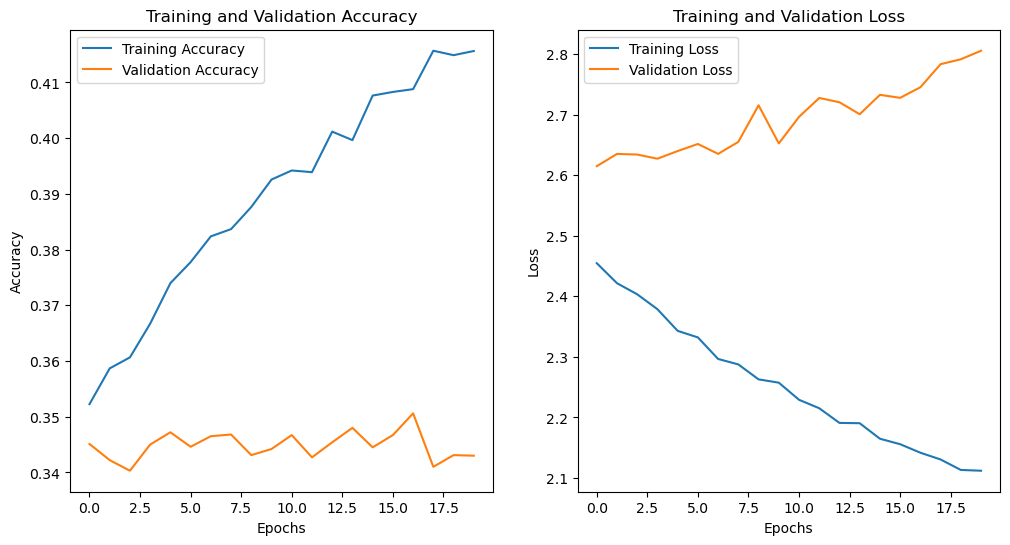

In [15]:
# Your code here
history = model.fit(
    x_train_split, y_train_split,
    epochs=20,
    batch_size=32,
    validation_data=(x_val_split, y_val_split)
)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

313/313 [==============================] - 2s 5ms/step


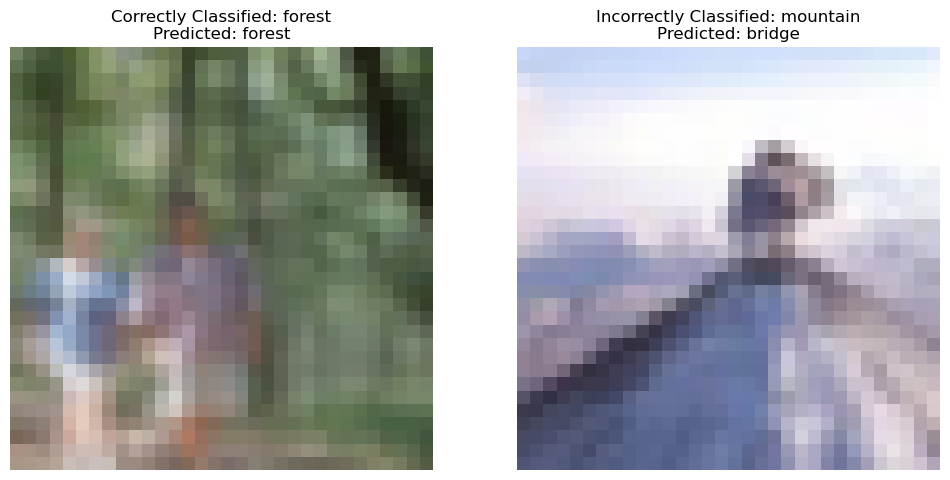

Probabilities for correctly classified image:
[4.2243073e-08 8.9383961e-05 8.4449621e-06 5.0449657e-05 1.6650579e-04
 2.7065610e-03 6.3549796e-06 4.3431032e-06 1.2150538e-03 8.5760001e-03
 4.2229080e-05 1.9513041e-05 4.7404487e-02 2.3200503e-04 2.8458318e-05
 2.1691715e-04 1.3440213e-04 3.3176344e-04 1.4614739e-02 1.7485623e-03
 4.8803540e-06 2.4045955e-06 4.0702813e-05 1.6243408e-06 1.0439812e-08
 3.2886048e-03 5.3764004e-05 4.9555544e-03 1.7445580e-05 1.1249892e-03
 4.6560763e-06 4.8781416e-04 8.2547849e-05 4.0450940e-01 1.3954887e-03
 3.0374404e-05 2.8210543e-06 4.4103111e-03 5.5119880e-03 2.4994719e-04
 4.9606396e-04 6.5593290e-06 9.3432248e-04 4.3895780e-06 5.6741773e-03
 1.3128553e-03 2.8514527e-05 1.4843266e-05 6.0365306e-07 2.6471736e-05
 2.9603881e-04 2.6370282e-03 9.7286931e-05 2.3993516e-12 1.2732428e-06
 1.2215428e-03 1.6265800e-02 1.4067267e-05 1.1509319e-06 9.4114052e-04
 3.0504134e-05 8.3125167e-07 3.5812442e-10 3.6636009e-04 3.5893876e-04
 1.4402360e-01 2.7404740e-04 1.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions for the test set
y_test_pred = model.predict(x_test_normalized)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = y_test.flatten()

# Find a correctly classified image
correct_indices = np.where(y_test_pred_labels == y_test_true_labels)[0]
incorrect_indices = np.where(y_test_pred_labels != y_test_true_labels)[0]

if len(correct_indices) > 0:
    correct_index = correct_indices[0]
    incorrect_index = incorrect_indices[0]

    # Plot correctly classified image
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[correct_index])
    plt.title(f"Correctly Classified: {class_names[y_test_true_labels[correct_index]]}\n"
              f"Predicted: {class_names[y_test_pred_labels[correct_index]]}")
    plt.axis('off')

    # Plot incorrectly classified image
    plt.subplot(1, 2, 2)
    plt.imshow(x_test[incorrect_index])
    plt.title(f"Incorrectly Classified: {class_names[y_test_true_labels[incorrect_index]]}\n"
              f"Predicted: {class_names[y_test_pred_labels[incorrect_index]]}")
    plt.axis('off')

    plt.show()

    # Print classification probabilities for each
    print("Probabilities for correctly classified image:")
    print(y_test_pred[correct_index])

    print("\nProbabilities for incorrectly classified image:")
    print(y_test_pred[incorrect_index])
else:
    print("No correctly or incorrectly classified images found.")

## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,        # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,    # Randomly translate images horizontally (fraction of total width)
    height_shift_range=0.1,   # Randomly translate images vertically (fraction of total height)
    horizontal_flip=True,     # Randomly flip images horizontally
    zoom_range=0.2,           # Randomly zoom into images
    shear_range=0.15          # Randomly shear images
)

# Fit the generator on the training data
datagen.fit(x_train_split)

# Train the model using the augmented data
history = model.fit(
    datagen.flow(x_train_split, y_train_split, batch_size=32),
    epochs=15,  # Number of epochs
    validation_data=(x_val_split, y_val_split),
    steps_per_epoch=len(x_train_split) // 32  # Calculate steps per epoch
)

Epoch 1/15
1250/1250 [==============================] - 84s 67ms/step - loss: 4.6060 - accuracy: 0.0095 - val_loss: 4.6060 - val_accuracy: 0.0090
Epoch 2/15
1250/1250 [==============================] - 81s 65ms/step - loss: 4.5979 - accuracy: 0.0108 - val_loss: 4.5596 - val_accuracy: 0.0192
Epoch 3/15
1250/1250 [==============================] - 88s 70ms/step - loss: 4.5538 - accuracy: 0.0191 - val_loss: 4.5344 - val_accuracy: 0.0202
Epoch 4/15
1250/1250 [==============================] - 78s 63ms/step - loss: 4.5369 - accuracy: 0.0214 - val_loss: 4.5219 - val_accuracy: 0.0215
Epoch 5/15
1250/1250 [==============================] - 74s 59ms/step - loss: 4.5254 - accuracy: 0.0222 - val_loss: 4.5112 - val_accuracy: 0.0237
Epoch 6/15
1250/1250 [==============================] - 80s 64ms/step - loss: 4.5177 - accuracy: 0.0221 - val_loss: 4.5033 - val_accuracy: 0.0246
Epoch 7/15
1250/1250 [==============================] - 83s 67ms/step - loss: 4.5102 - accuracy: 0.0234 - val_loss: 4.4975 -

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

In [ ]:
# Your code here
history = model.fit(
    datagen.flow(x_train_split, y_train_split, batch_size=32),
    epochs=30,  # Number of epochs
    validation_data=(x_val_split, y_val_split),
    steps_per_epoch=len(x_train_split) // 32  # Calculate steps per epoch
)

In [ ]:
# Compare accuracy and other metrics on the test set

# Predict on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Calculate accuracy
enhanced_accuracy = accuracy_score(y_test_classes, y_pred_classes)

# Calculate precision
enhanced_precision = precision_score(y_test_classes, y_pred_classes, average='weighted')

# Report the enhanced metrics
print(f"Enhanced Model Accuracy: {enhanced_accuracy}")
print(f"Enhanced Model Precision: {enhanced_precision}")

### Task 4c: Discussion of the results

- Briefly discuss the results. 
- Did the model's performance improve? 
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here

The model's performance improved significantly after applying data augmentation. The higher accuracy and precision on the test set show that the model became better at generalizing to new data. 
This improvement likely came from training on a more varied set of images, which helped the model learn more robust features.
There's still room for further improvement, though. The current accuracy suggests the model may have trouble distinguishing between some classes. To enhance performance, we could try adding more layers, using different network architectures, or experimenting with regularization techniques like L2 regularization.
It would be also beneficial to trying techniques like transfer learning. Using a pre-trained model on a large dataset like ImageNet and fine-tuning it on CIFAR-100 might help the model achieve even better results. This approach could leverage the rich feature representations learned from a much larger dataset, leading to improved accuracy and generalization.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.